# Bayesian Learning Lab2

Author : Yunan Dong, Yifan Ding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Q1

## a)

In [2]:
with open('TempLinkoping.txt','r') as f:
    doc = f.readlines()
    doc = doc[1:]
    for i in range(len(doc)):
        doc[i] = doc[i].split('\t')
        doc[i] = [float(doc[i][0]), float(doc[i][-1])]
    doc = np.array(doc)
time = doc[:,0]
temp = doc[:,1]

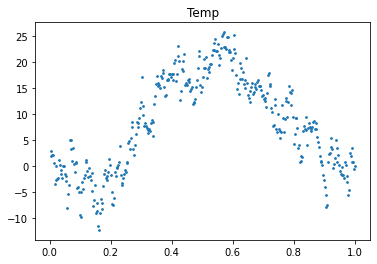

In [3]:
plt.figure(0)
plt.scatter(time, temp,s=3)
plt.title('Temp')
plt.show()

In [4]:
mu_0 = np.array([-10, 100, -100])
omega_0 = 0.01 * np.eye(3)
v_0 = 4
sigma2_0 = 1

In [5]:
# Draw sigma^2 from inv-x
sigma2s = sigma2_0 * v_0 / np.random.chisquare(v_0, size=20)

# Draw beta from multi-norm
betas = []
for sigma2 in sigma2s:
    beta = np.random.multivariate_normal(mu_0, sigma2 * np.linalg.inv(omega_0))
    betas.append(beta)
betas = np.array(betas)
betas = betas.T

In [6]:
def build_x_matrix(time):
    time = time.reshape(-1, 1)
    ones = np.ones(time.shape)
    time2 = time ** 2
    x = np.concatenate((ones, time, time2), axis=1)
    
    return x


def quadratic_model(time, betas):
    x = build_x_matrix(time)
    ys = x @ betas
    return ys

ys = quadratic_model(time, betas)
ys.shape

(365, 20)

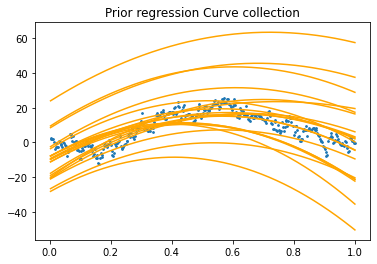

In [7]:
# plot 1000 regression draws
plt.figure(1)
plt.scatter(time, temp,s=3)
for i in range(ys.shape[1]):
    plt.plot(time, ys[:,i],color='orange')
plt.title('Prior regression Curve collection')
plt.show()

Answer: The prior regression curves looks like a very good assumption for those data points, thus we didn't propose new alternative prior.

## b)

In [8]:
X = build_x_matrix(time)
y = temp.reshape(-1, 1)
mu_0 = mu_0.reshape(-1, 1)

# beta_hat is the least-square solution
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y 

# posterior parameters
omega_n = X.T @ X + omega_0
mu_n = np.linalg.inv(omega_n) @ (X.T @ y + omega_0 @ mu_0)
n = y.shape[0]
v_n = v_0 + n
vn_sigma2_n = v_0 * sigma2_0 + (y.T @ y + mu_0.T @ omega_0 @ mu_0 - mu_n.T @ omega_n @ mu_n)
vn_sigma2_n

array([[9767.25888292]])

In [9]:
mu_n.shape

(3, 1)

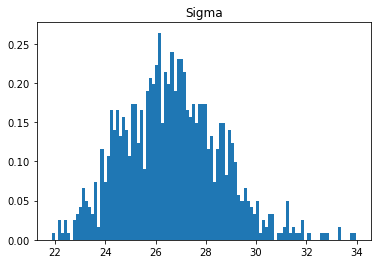

In [10]:
# sigma hist
sigma_posterior = vn_sigma2_n[0] / (np.random.chisquare(v_n, size=1000) + 1e-4)
plt.figure(2)
plt.hist(sigma_posterior, density=True, bins=100)
plt.title('Sigma')
plt.show()

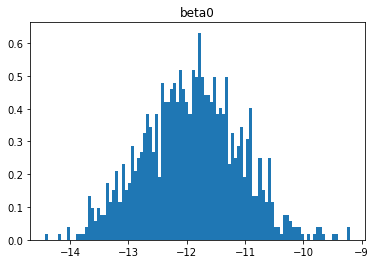

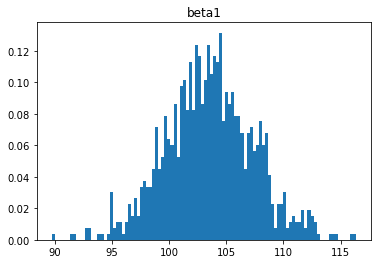

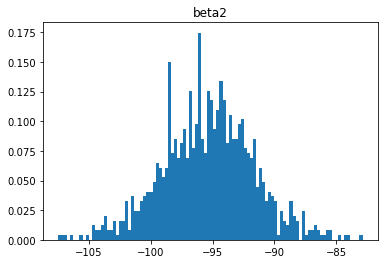

In [11]:
betas_post = []
for sigma2 in sigma_posterior:
    beta = np.random.multivariate_normal(mu_n.reshape(-1), sigma2 * np.linalg.inv(omega_n))
    betas_post.append(beta)
betas_post = np.array(betas_post)
betas_post = betas_post.T

# beta hist
for i in range(3):
    plt.figure(i+3)
    plt.hist(betas_post[i, :], density=True, bins=100)
    plt.title('beta{}'.format(i))
    plt.show()

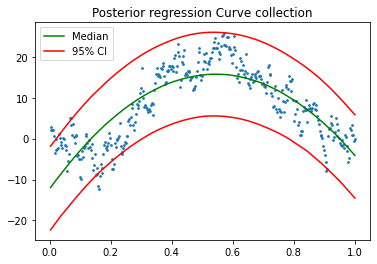

In [12]:
ys_post = quadratic_model(time, betas_post) + np.random.normal(0, np.sqrt(sigma_posterior))
ys_low = np.percentile(ys_post, 2.5, axis=1)
ys_high = np.percentile(ys_post, 97.5, axis=1)
ys_median = np.median(ys_post, axis=1)

plt.figure(1)
plt.scatter(time, temp,s=3)
plt.plot(time, ys_median,color='green', label='Median')
plt.plot(time, ys_low,color='red',label='95% CI')
plt.plot(time, ys_high,color='red')
plt.title('Posterior regression Curve collection')
plt.legend()
plt.show()

Question :Does the posterior probability intervals contain most of the data points? Should they?

Answer: No, the probability intervals didn't contain most of the point. And they shouldn't contain most data points, because this interval indicate the uncertainty of beta instead of the uncertainty of model (residual).

## c) 

$$y = \beta_0 + \beta_1 x+ \beta_2 x^2$$

When $y\prime= 0$, easy to get:

$$x = - \frac{\beta_1}{2\beta_2}$$

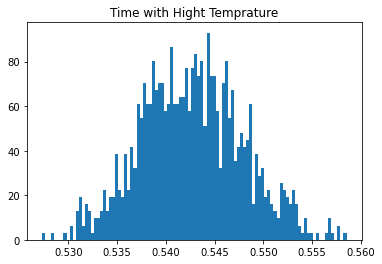

In [13]:
y_maxs = np.max(ys_post,axis=0)
x_maxs =  - betas_post[1, :] / (2 * betas_post[2, :])

plt.figure(6)
plt.hist(x_maxs, density=True, bins=100)
plt.title('Time with Hight Temprature')
plt.show()

## d)

A L2 regularization prior could be a good alternative:

$$ \beta|\sigma \sim N(0, \frac{\sigma^2}{\lambda})$$

Where lambda is the penalty factor.

# Q2

## a)

In [14]:
# Read file
with open('WomenWork.dat') as f:
    doc = f.readlines()
    doc = doc[1:]
    for i in range(len(doc)):
        doc[i] = np.array(doc[i].split('  ')[1:]).astype(float)
        
doc = np.array(doc)
y = doc[:, 0].reshape(-1, 1)
X = doc[:, 1:]

In [15]:
# prior parameters
Lambda = 1
mu = np.zeros((X.shape[1], 1))
sigma = 100 * np.eye(X.shape[1]) / Lambda

Hessian is calculated by following fomular .

First order derivative for log prior:

$$ -logp(\beta) = \frac{N}{2}log(2\pi) + \frac{1}{2}log|\Sigma| + \frac{1}{2}(\beta - \mu)^T \Sigma^{-1} (\beta - \mu)$$

$$\frac{\partial (-logp(\beta))}{\partial \beta} = \Sigma^{-1} (\beta - \mu)$$


First order derivative for loglikelihood:
$$ -loglik = - (X \beta)^T Y + \sum log(1 + exp(X \beta))$$


$$ \frac{\partial (-loglik)}{\partial \beta} =  - X^T Y + X^T \frac{exp(X\beta)}{1 + exp(X\beta)}$$ 


Thus the overall Jacobian are:

$$J = \Sigma^{-1} (\beta - \mu) - X^T Y + X^T \frac{exp(X\beta)}{1 + exp(X\beta)}$$

Second order derivatives:

$$ \frac{\partial ^2 (-logp(\beta))}{\partial \beta \partial \beta^T}  = \Sigma^{-1}$$ 


$$ \frac{\partial ^2 (-loglik)}{\partial \beta \partial \beta^T}  = 0 +  X^T \frac{\partial u}{\partial \beta} = X^T  \frac{\partial u}{\partial \beta}$$ 

Where $u = \frac{exp(X\beta)}{1 + exp(X\beta)}$, thus:


$$ \frac{\partial ^2 (-loglik)}{\partial \beta \partial \beta^T} = X^T (\frac{exp(-X\beta)}{(1 + exp(-X\beta))^2} .* X)$$

Note $.*$ is element-wise multiplication, and the overall Hessian Matrix is:

$$H = \frac{\partial ^2 (-logp(\beta))}{\partial \beta \partial \beta^T} + \frac{\partial ^2 (-loglik)}{\partial \beta \partial \beta^T} = \Sigma^{-1} + X^T (\frac{exp(-X\beta)}{(1 + exp(-X\beta))^2} .* X)$$



In [16]:
def log_logistic(betas, y, X, mu, sigma):
    linPred = X @ betas
    loglik = - linPred.T @ y + np.sum(np.log(1 + np.exp(linPred)))
    logprior =  - np.log(multivariate_normal.pdf(betas[:,0], mean=mu[:,0], cov=sigma))
    return loglik + logprior

def sigmoid(x):
    y = np.exp(x) / (1 + np.exp(x))
    return y

def grad_beta(betas, y, X, mu, sigma):
    linPred = X @ betas
    prior = np.linalg.inv(sigma) @ (betas - mu) 
    sig= sigmoid(linPred)
    likhood = - X.T @ y + X.T @ sig
    grad = likhood  + prior
    return grad

def hessian(betas, sigma, X):
    linePred = X @ betas
    sig = sigmoid(linePred)
    sigmoid_derivative = sig * (1 - sig)
    h = np.linalg.inv(sigma) + X.T @ (sigmoid_derivative * X)
    return h

def update_beta(betas, lr, grad, hessian=None):
    # Newton method
    if hessian:
        betas = betas -  lr * np.linalg.inv(hessian) @ grad
    # Gradiant descent
    else:
        betas = betas -  lr * grad
    return betas

In [17]:
# init beta and learning rate
betas = np.ones([X.shape[1], 1])
lr = 0.00001
iterations = 60000

for i in range(iterations):
    
    posterior = log_logistic(betas, y, X, mu, sigma)
    grad = grad_beta(betas, y, X, mu, sigma)
    # hess = hessian(betas, sigma, X)
    betas = update_beta(betas, lr, grad)
    
print('The posterior is {}'.format(posterior[0][0]))
print('Betas:')
print(betas)

The posterior is 137.15299816973948
Betas:
[[ 0.72400564]
 [-0.0195235 ]
 [ 0.17572365]
 [ 0.16644417]
 [-0.14062482]
 [-0.08295944]
 [-1.34718903]
 [-0.02909212]]


In [18]:
# inverse Hessian
hess = hessian(betas, sigma, X)
invhess= np.linalg.inv(hess)
print('Inverse Hessian Matrix')
print(invhess)

# The 95% credible interval:

sigma_6 = np.diag(invhess)[6]
std_6 = np.sqrt(sigma_6)
upbound = betas[6] + 1.96 * std_6
lowbound = betas[6] - 1.96 * std_6

print('Standard deviation : {}'.format(std_6))
print('The 95 % interval is ({}, {})'.format(upbound,lowbound))

Inverse Hessian Matrix
[[ 2.26313990e+00  3.31082635e-03 -6.52007239e-02 -1.16434708e-02
   4.57458085e-02 -3.03128670e-02 -1.89778207e-01 -9.78279825e-02]
 [ 3.31082635e-03  2.51581489e-04 -5.57949388e-04 -3.01859617e-05
   1.40144397e-04 -3.57127155e-05  4.95950313e-04 -1.42884130e-04]
 [-6.52007239e-02 -5.57949388e-04  6.18994260e-03 -3.60461314e-04
   1.88333148e-03 -1.13252893e-06 -6.02999439e-03  1.74138938e-03]
 [-1.16434708e-02 -3.01859617e-05 -3.60461314e-04  4.35028361e-03
  -1.42628532e-02 -1.35547249e-04 -1.46127794e-03  5.34050906e-04]
 [ 4.57458085e-02  1.40144397e-04  1.88333148e-03 -1.42628532e-02
   5.56960784e-02 -3.26234652e-04  3.22778106e-03  5.27011785e-04]
 [-3.03128670e-02 -3.57127155e-05 -1.13252893e-06 -1.35547249e-04
  -3.26234652e-04  7.18294398e-04  5.18072397e-03  1.09557537e-03]
 [-1.89778207e-01  4.95950313e-04 -6.02999439e-03 -1.46127794e-03
   3.22778106e-03  5.18072397e-03  1.50368904e-01  6.81932065e-03]
 [-9.78279825e-02 -1.42884130e-04  1.74138938e

## b)

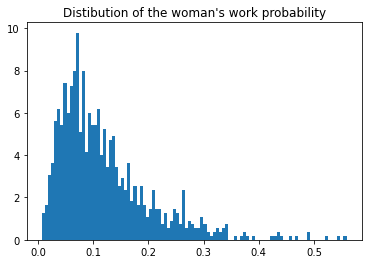

In [19]:
def predict(X, betas):
    logits = sigmoid(betas @ X.T)
    #y = float(logits > 0.5)
    return(logits)

woman = np.array([[1, 13, 8, 11, (11/10)**2, 37, 2, 0]])
draws = np.random.multivariate_normal(betas[:,0], invhess, size=1000)
probs = predict(woman, draws)

plt.figure(7)
plt.hist(probs, density=True, bins=100)
plt.title("Distibution of the woman's work probability")
plt.show()

## c)

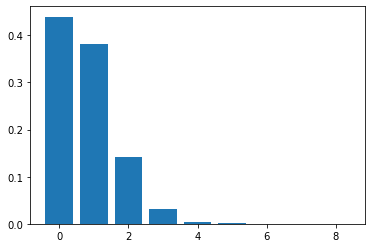

In [20]:
expected_prob = predict(woman, betas.reshape(1, -1))
binom = np.random.binomial(8, expected_prob[0], 10000)

heights = []
for i in range(9):
    h = np.sum(binom == i) / 10000
    heights.append(h)

plt.figure(9)
plt.bar(x=np.arange(9), height=heights)
plt.show()